In [1]:
import timm
from torchsummary import summary
import torch
from torch import nn
import torch.nn.functional as F
from importlib import reload
import cv2
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import albumentations
from albumentations import augmentations
import albumentations.pytorch
from albumentations.pytorch.functional import img_to_tensor
from tqdm import tqdm
from tqdm import tqdm_notebook
from torch.utils.data import DataLoader
import wandb

In [9]:
from dataset import DATASET
import seg_metrics
from pytorch_toolbelt import losses
from utils import *
# import segmentation_models_pytorch as smp
from segmentation.timm_unetpp import UnetPP
from segmentation.merged_net import SRM_Classifer 

In [10]:
encoder = SRM_Classifer(encoder_checkpoint='best_weights/CASIA_FULL_ELA.h5', freeze_encoder=False)
model = UnetPP(encoder, in_channels=54, num_classes=1)
model.to('cuda')
model = nn.DataParallel(model)
model.load_state_dict(torch.load('best_weights/CASIA_64_UNETPP_END-END.h5'))

--------- Loaded Checkpoint: best_weights/CASIA_FULL_ELA.h5 ----------
<All keys matched successfully>


<All keys matched successfully>

In [11]:
def valid_epoch(model, valid_loader):
    model.eval()

    targets = []
    outputs = []
    example_images = []
    image_names = []

    with torch.no_grad():
        for batch in tqdm(valid_loader):
            images = batch["image"].to('cuda')
            elas = batch["ela"].to('cuda')
            gt = batch["mask"].to('cuda')
            
            out_mask = model(images, elas)

            out_mask = torch.sigmoid(out_mask.cpu())
            gt = gt.cpu()
            
            targets.extend(list(gt))
            outputs.extend(list(out_mask))
            example_images.extend(list(images.cpu()))
            image_names.extend(batch["image_path"])

    print("~~~~~~~~~~~~~~~~~~~~~~~~~")       
    dice, best_dice = seg_metrics.dice_coeff(outputs, targets)  
    jaccard, best_iou = seg_metrics.jaccard_coeff(outputs, targets) 
    print("~~~~~~~~~~~~~~~~~~~~~~~~~")
        
    valid_metrics = {
        "valid_dice": dice.item(),
        "valid_jaccard": jaccard.item(),
    }

    return valid_metrics

In [12]:
def get_loader(aug):
    normalize = {
        "mean": [0.42468103282400615, 0.4259826707370029, 0.38855473517307415],
        "std": [0.2744059987371694, 0.2684138285232067, 0.29527622263685294],
    }

    valid_aug = albumentations.Compose(
        [
            augmentations.transforms.Resize(224, 224, interpolation=cv2.INTER_AREA, always_apply=True, p=1),
            albumentations.Normalize(mean=normalize['mean'], std=normalize['std'], always_apply=True, p=1),
            albumentations.pytorch.ToTensor()
        ],
        additional_targets={'ela':'image'}
    )

    df = pd.read_csv(f"casia_64.csv").sample(frac=1).reset_index(drop=True)
    valid_dataset = DATASET(
        dataframe=df,
        mode="val",
        val_fold=0,
        test_fold=9,
        patch_size=64,
        augment=aug,
        transforms=valid_aug,
        segment=True
    )
    valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True, num_workers=8)

    return valid_loader

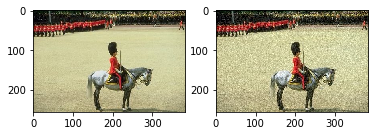

In [4]:
import imgaug.augmenters as iaa
aug = iaa.AdditiveGaussianNoise()

img = cv2.imread('Image_Manipulation_Dataset/CASIA_2.0/Au/Au_cha_30212.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
new_img = aug.augment_image(image=img)

plt.figure(1)
plt.subplot(121)
plt.imshow(img)

plt.subplot(122)
plt.imshow(new_img)

plt.imsave('noisy.png', new_img)
plt.show()

In [14]:
wandb.init(
    project="imanip", name=f"GaussianBlur",
)
for k in range(3,34,2):
    # aug = iaa.MotionBlur(k=k)
    aug = k
    valid_loader = get_loader(aug)
    ret = valid_epoch(model, valid_loader)
    print(ret)
    wandb.log(ret)
    wandb.log({'k':k})

wandb: ERROR Control-C detected -- Run data was not synced


 14%|█▎        | 13/96 [00:06<00:43,  1.93it/s]


KeyboardInterrupt: 